In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

save_directory = "longformer_model"

tokenizer = AutoTokenizer.from_pretrained(save_directory)
model = AutoModelForSequenceClassification.from_pretrained(save_directory)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
          

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_df = pd.read_csv("data/Gungor_2018_VictorianAuthorAttribution_data-train.csv", encoding="ISO-8859-1")
train_df['author_label'] = train_df['author'].astype('category').cat.codes

# Use whatever split you originally used

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].tolist(),
    train_df['author_label'].tolist(),
    test_size=0.1,
    stratify=train_df['author_label'],
    random_state=42
)


In [3]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F

batch_size = 4  # Adjust based on your VRAM

val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=4096, return_tensors="pt")
val_dataset = torch.utils.data.TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'])

val_loader = DataLoader(val_dataset, batch_size=batch_size)

all_preds = []
all_labels = []
all_confidences = []

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        input_ids, attention_mask = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        probs = F.softmax(logits, dim=-1)
        confidences, preds = torch.max(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_confidences.extend(confidences.cpu().numpy())
        all_labels.extend(val_labels[batch_idx * batch_size: (batch_idx + 1) * batch_size])


  0%|          | 0/1342 [00:00<?, ?it/s]Initializing global attention on CLS token...
Input ids are automatically padded to be a multiple of `config.attention_window`: 512
100%|██████████| 1342/1342 [03:49<00:00,  5.85it/s]


Accuracy: 0.9667
Macro F1 Score: 0.9545


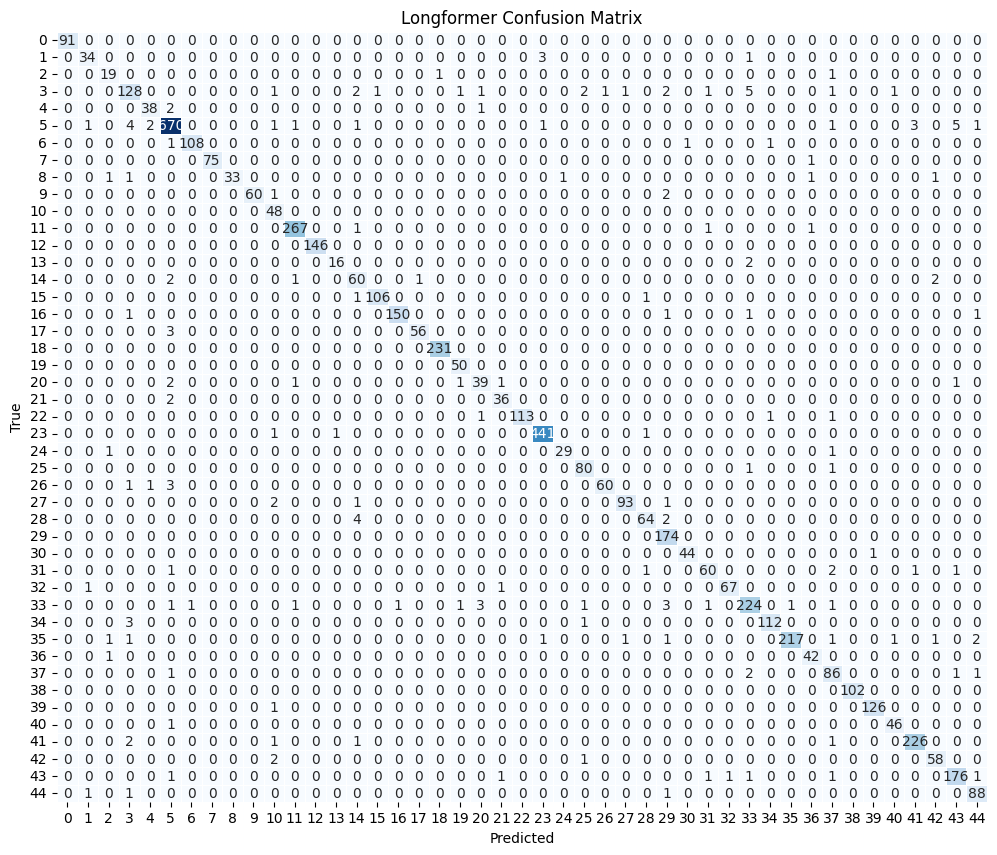

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        91
           1     0.9189    0.8947    0.9067        38
           2     0.8261    0.9048    0.8636        21
           3     0.9014    0.8649    0.8828       148
           4     0.9268    0.9268    0.9268        41
           5     0.9710    0.9696    0.9703       691
           6     0.9908    0.9730    0.9818       111
           7     1.0000    0.9868    0.9934        76
           8     1.0000    0.8684    0.9296        38
           9     1.0000    0.9524    0.9756        63
          10     0.8276    1.0000    0.9057        48
          11     0.9852    0.9889    0.9871       270
          12     1.0000    1.0000    1.0000       146
          13     0.9412    0.8889    0.9143        18
          14     0.8451    0.9091    0.8759        66
          15     0.9907    0.9815    0.9860       108
          16     0.9934    0.9740    0.9836       154
          17     0.9825    

In [4]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {acc:.4f}")

# F1 Score (macro, treats each class equally)
f1 = f1_score(all_labels, all_preds, average="macro")
print(f"Macro F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", annot=True, fmt="d", linewidths=0.5, cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Longformer Confusion Matrix")
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, digits=4))


In [5]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example for DistilBERT or any loaded model
num_params = count_trainable_params(model)
print(f"Number of trainable parameters: {num_params:,}")


Number of trainable parameters: 148,694,061


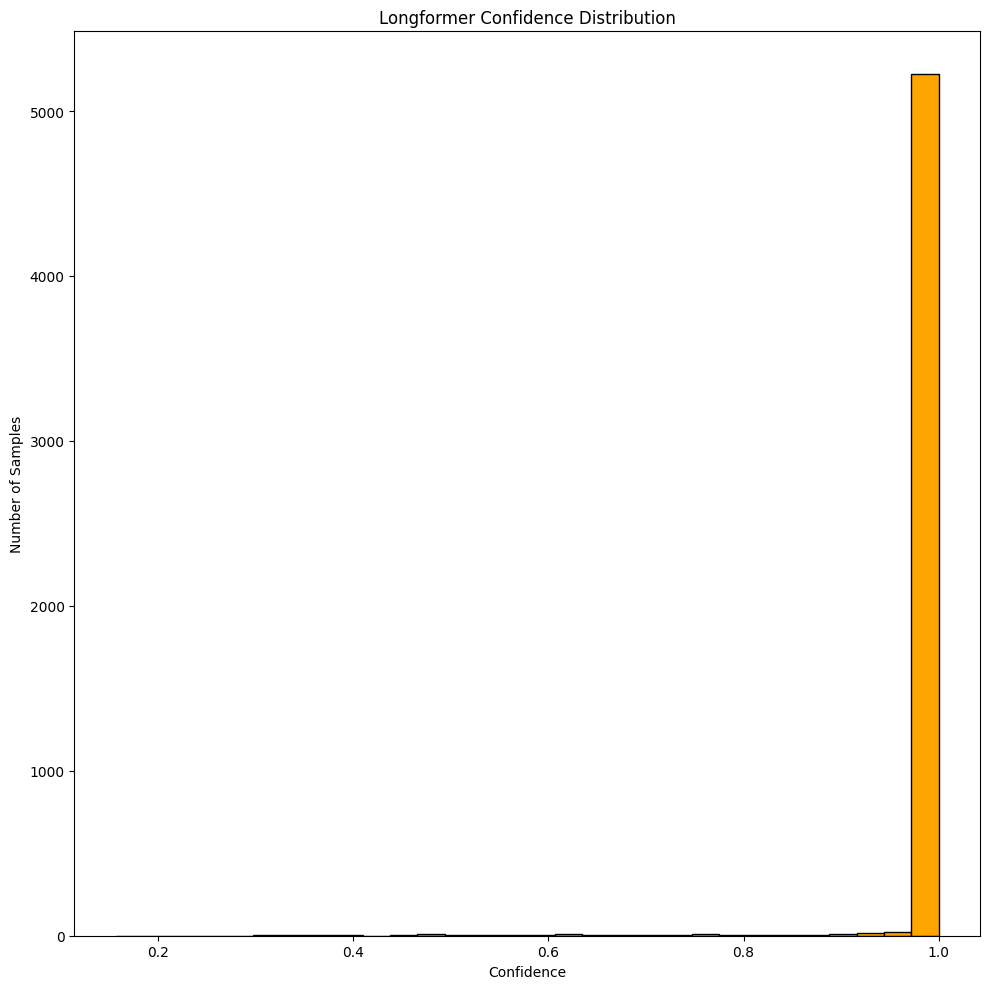

In [6]:
# Confidence histogram
plt.figure(figsize=(10, 10))
plt.hist(all_confidences, bins=30, color='orange', edgecolor='black')
plt.title("Longformer Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()